**Generating Mock Data**

In [32]:
import pandas as pd
import numpy as np
from datetime import datetime

# Generate mock sales data
np.random.seed(42)

start_date = datetime(2020, 1, 1)
num_months = 48  # 4 years of monthly data

date_rng = pd.date_range(start_date, periods=num_months, freq='MS')  # MS for Month Start
sales_data = pd.DataFrame(date_rng, columns=['Date'])

# Base sales with a slight upward trend
base_sales = 10000 + np.arange(num_months) * 50

# Seasonal component (higher in Q4, lower in Q1)
seasonal_component = (
    2000 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 12 + np.pi / 2) +
    1500 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 6)
)

# Random noise
noise = np.random.normal(0, 500, num_months)

# Calculate final sales amount
sales_data['SalesAmount'] = (base_sales + seasonal_component + noise).astype(int)
sales_data['SalesAmount'] = sales_data['SalesAmount'].clip(lower=2000)  # Ensure sales are positive

# Add promotional flags (randomly)
sales_data['Promotion'] = np.random.choice([0, 1], num_months, p=[0.8, 0.2])
sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'] *= np.random.uniform(1.1, 1.3)

# Add holiday flags (e.g., December)
sales_data['HolidayMonth'] = (sales_data['Date'].dt.month == 12).astype(int)
sales_data.loc[sales_data['HolidayMonth'] == 1, 'SalesAmount'] *= np.random.uniform(1.15, 1.4)

# Final cleanup
sales_data['SalesAmount'] = sales_data['SalesAmount'].astype(int)


In [ ]:
# Save the generated data to a CSV file
sales_data.to_csv('monthly_sales_data.csv', index=False)

In [ ]:
from google.colab import files
files.download("monthly_sales_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Importing Data and Other Dependenices**

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [34]:
sales_data = pd.read_csv("/content/monthly_sales_data.csv")

In [35]:
sales_data.head()

,Date,SalesAmount,Promotion,HolidayMonth
0,2020-01-01,12248,0,0
1,2020-02-01,13011,0,0
2,2020-03-01,12722,0,0
3,2020-04-01,14030,1,0
4,2020-05-01,7783,0,0


**Data Exploration and Preprocessing**

In [36]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          48 non-null     object
 1   SalesAmount   48 non-null     int64 
 2   Promotion     48 non-null     int64 
 3   HolidayMonth  48 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.6+ KB


Here we can see that date is in object format so lets change this.

In [37]:
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
sales_data.set_index('Date', inplace=True) # setted as index
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalesAmount   48 non-null     int64
 1   Promotion     48 non-null     int64
 2   HolidayMonth  48 non-null     int64
dtypes: int64(3)
memory usage: 1.5 KB


In [38]:
print(sales_data.loc['2020-07-01', 'SalesAmount'])

9089


**Exploratory Data Analysis**

**1--> Visualizing Sales Over Time**

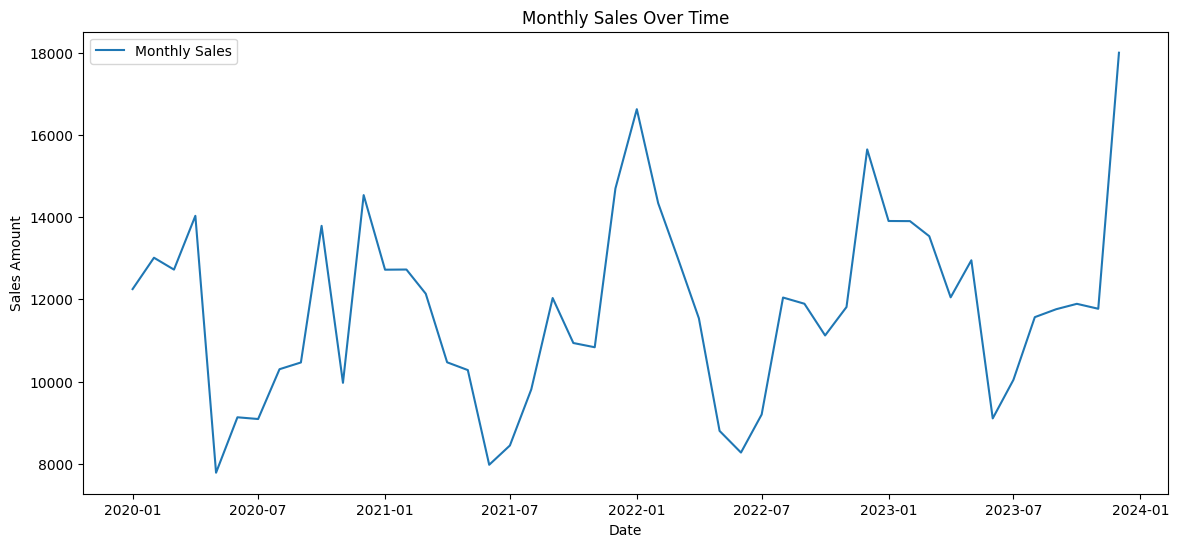

In [39]:
plt.figure(figsize=(14, 6))
plt.plot(sales_data['SalesAmount'], label='Monthly Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()

**2--> Decompostion Plot**

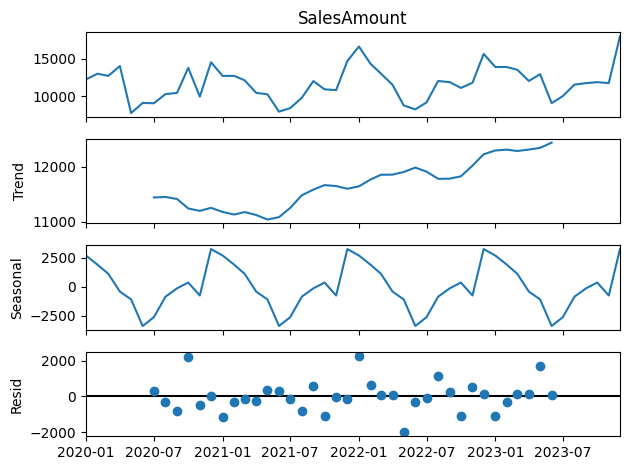

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing with additive model
decomposition = seasonal_decompose(sales_data['SalesAmount'], model='additive')

decomposition.plot()
plt.show()


**Insights**  
Sales are growing over time — positive trend.

There's a strong seasonal pattern — possibly yearly cycles.

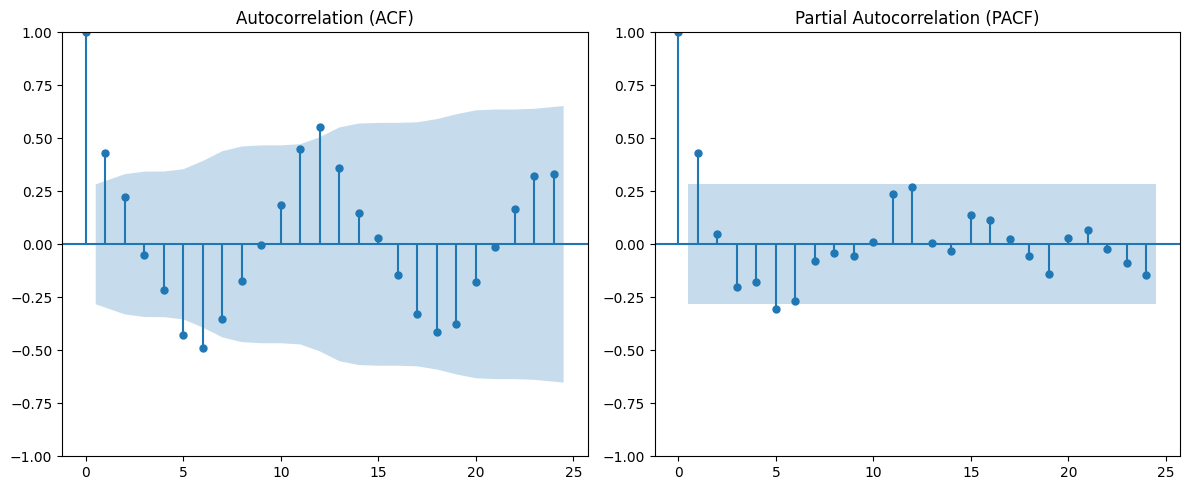

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(sales_data['SalesAmount'], lags=24, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(sales_data['SalesAmount'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()


ACF plot shows strong positive autocorrelation at lag 1 and significant seasonality at lag 12, indicating a yearly seasonal pattern.

The simultaneous decay in both ACF and PACF suggests an ARIMA model is suitable, while the prominent spike at lag 12 in the ACF confirms the presence of strong seasonality, making a SARIMA model the more appropriate choice.

**3--> Dickey Fuller Test**

In [42]:
from statsmodels.tsa.stattools import adfuller

# Run the ADF test on your SalesAmount column
adf_result = adfuller(sales_data['SalesAmount'])

# Display results
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.5141835977339575
p-value: 0.00018535586430261453
Critical Values:
   1%: -3.596635636000432
   5%: -2.933297331821618
   10%: -2.6049909750566895


This means our data is **stationary** as value of p < 0.5. So we reject our null hypothesis that data is not stationary.

In [43]:
sales_data.isnull().sum()

,0
SalesAmount,0
Promotion,0
HolidayMonth,0


**Feature Engineering**

In [44]:
# Add lag features cuz of spike after every 12 month
for lag in range(1, 13):
    sales_data[f'lag_{lag}'] = sales_data['SalesAmount'].shift(lag)

print(sales_data.head())


            SalesAmount  Promotion  HolidayMonth    lag_1    lag_2    lag_3  \
Date                                                                          
2020-01-01        12248          0             0      NaN      NaN      NaN   
2020-02-01        13011          0             0  12248.0      NaN      NaN   
2020-03-01        12722          0             0  13011.0  12248.0      NaN   
2020-04-01        14030          1             0  12722.0  13011.0  12248.0   
2020-05-01         7783          0             0  14030.0  12722.0  13011.0   

              lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  
Date                                                                            
2020-01-01      NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN  
2020-02-01      NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN  
2020-03-01      NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN  
2020-04-01      NaN    NaN    NaN    NaN 

In [45]:
# Creating a 'HolidaySeason' feature
sales_data['HolidaySeason'] = sales_data.index.month.isin([11, 12]).astype(int)

# 3. Create interaction features
sales_data['Promo_and_Holiday'] = sales_data['Promotion'] * sales_data['HolidaySeason']

In [46]:
print(sales_data[['Promotion', 'HolidaySeason', 'Promo_and_Holiday']].head(15))


            Promotion  HolidaySeason  Promo_and_Holiday
Date                                                   
2020-01-01          0              0                  0
2020-02-01          0              0                  0
2020-03-01          0              0                  0
2020-04-01          1              0                  0
2020-05-01          0              0                  0
2020-06-01          1              0                  0
2020-07-01          0              0                  0
2020-08-01          0              0                  0
2020-09-01          0              0                  0
2020-10-01          1              0                  0
2020-11-01          0              1                  0
2020-12-01          0              1                  0
2021-01-01          0              0                  0
2021-02-01          0              0                  0
2021-03-01          0              0                  0


In [47]:
sales_data.head()


,SalesAmount,Promotion,HolidayMonth,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,HolidaySeason,Promo_and_Holiday
Date,,,,,,,,,,,,,,,,,
2020-01-01,12248,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-02-01,13011,0,0,12248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-03-01,12722,0,0,13011.0,12248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-04-01,14030,1,0,12722.0,13011.0,12248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-05-01,7783,0,0,14030.0,12722.0,13011.0,12248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


**Model Training**

In [48]:
# Training set: first 36 months
train_data = sales_data.iloc[:36]

# Validation set: last 12 months
valid_data = sales_data.iloc[36:]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()}")
print(f"Validation data from {valid_data.index.min()} to {valid_data.index.max()}")

Training data from 2020-01-01 00:00:00 to 2022-12-01 00:00:00
Validation data from 2023-01-01 00:00:00 to 2023-12-01 00:00:00


In [49]:
# External regressors (Promotion, HolidayMonth)
exog_vars = sales_data[['Promotion', 'HolidayMonth']]

train_exog = exog_vars.iloc[:36]
valid_exog = exog_vars.iloc[36:]

In [50]:
# ------------------------------------------------- ARIMA ------------------------------------------------#


                               SARIMAX Results                                
Dep. Variable:            SalesAmount   No. Observations:                   36
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -317.771
Date:                Sun, 25 May 2025   AIC                            647.541
Time:                        08:53:48   BIC                            657.043
Sample:                    01-01-2020   HQIC                           650.858
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.144e+04     71.010    161.063      0.000    1.13e+04    1.16e+04
ar.L1          1.5996      0.190      8.429      0.000       1.228       1.972
ar.L2         -0.8314      0.158     -5.268      0.0

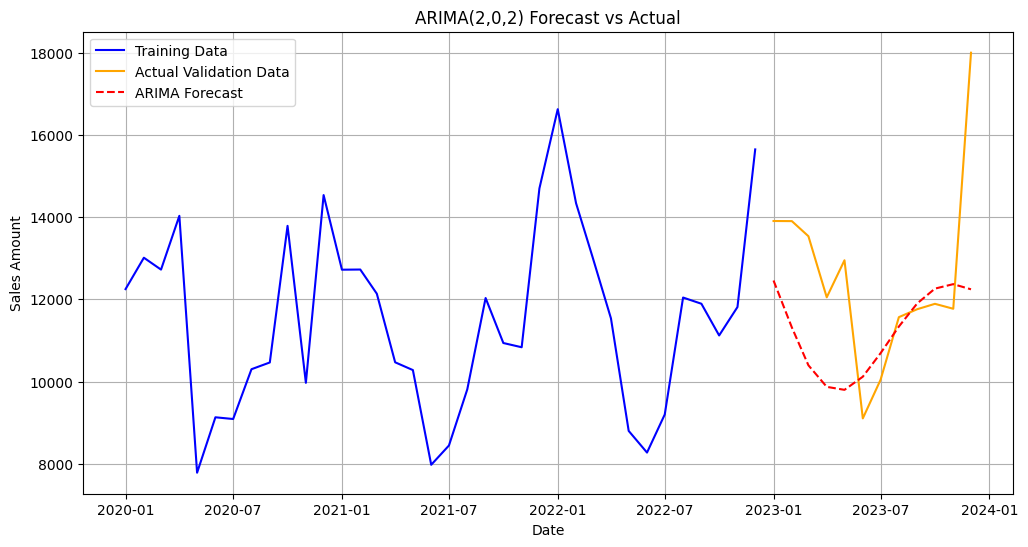

In [63]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model on training data
arima_model = ARIMA(train_data['SalesAmount'], order=(2, 0, 2))
arima_result = arima_model.fit()

# Summary of the model
print(arima_result.summary())

# Forecasting on validation data (next 12 months)
forecast = arima_result.forecast(steps=len(valid_data))
forecast = pd.Series(forecast, index=valid_data.index)

# Plotting actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['SalesAmount'], label='Training Data', color = 'blue')
plt.plot(valid_data.index, valid_data['SalesAmount'], label='Actual Validation Data',color = 'orange')
plt.plot(valid_data.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('ARIMA(2,0,2) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
#--------------------------------------------- SARIMAX ------------------------------------------#

                                      SARIMAX Results                                       
Dep. Variable:                          SalesAmount   No. Observations:                   36
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -355.475
Date:                              Sun, 25 May 2025   AIC                            728.949
Time:                                      08:44:07   BIC                            743.201
Sample:                                  01-01-2020   HQIC                           733.924
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
HolidayMonth  1.464e+04   8.72e-06   1.68e+09      0.000    1.46e+04    1.46e+04
Promotion    

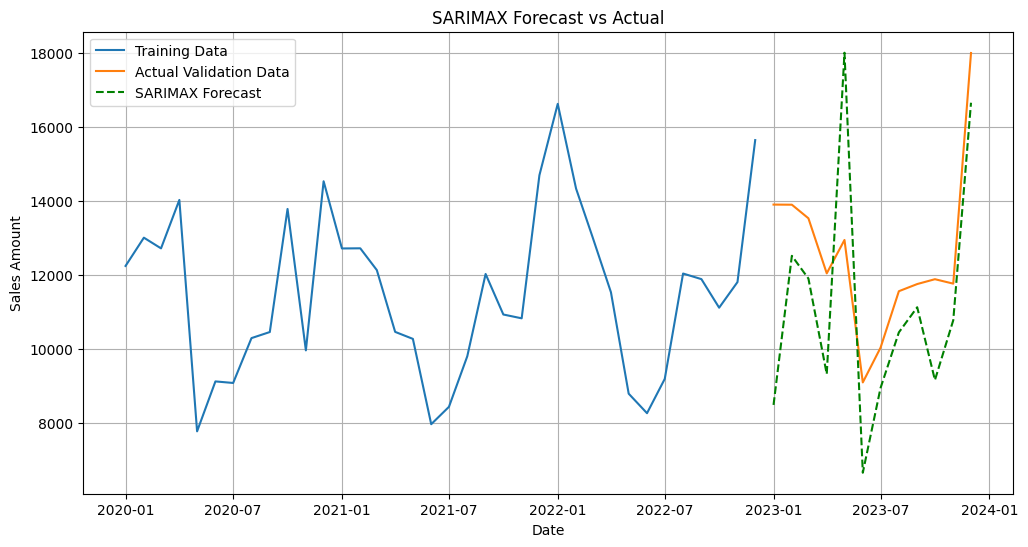

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Fit the SARIMAX model on training data
sarimax_model = SARIMAX(train_data['SalesAmount'],
                        order=(2, 0, 2), #(p,d,q)
                        seasonal_order=(1, 0, 1, 12), #(P,D,Q,s)
                        exog=train_data[['HolidayMonth', 'Promotion']])  # external regressors if any

sarimax_result = sarimax_model.fit()

# Summary of the model
print(sarimax_result.summary())

# Forecasting on validation data (next 12 months)
# Pass external regressors for validation period as well
sarimax_forecast = sarimax_result.forecast(steps=len(valid_data), exog=valid_data[['HolidayMonth', 'Promotion']])
sarimax_forecast = pd.Series(sarimax_forecast, index=valid_data.index)

# Plotting actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['SalesAmount'], label='Training Data')
plt.plot(valid_data.index, valid_data['SalesAmount'], label='Actual Validation Data')
plt.plot(valid_data.index, sarimax_forecast, label='SARIMAX Forecast', color='green', linestyle='--')
plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
#------------------------------------------- PROPHET ----------------------------------------#

DEBUG:cmdstanpy:input tempfile: /tmp/tmpu9k9cly0/8_5v8x2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu9k9cly0/xa08skm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21497', 'data', 'file=/tmp/tmpu9k9cly0/8_5v8x2e.json', 'init=/tmp/tmpu9k9cly0/xa08skm_.json', 'output', 'file=/tmp/tmpu9k9cly0/prophet_modelyellswix/prophet_model-20250525085612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:56:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:56:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


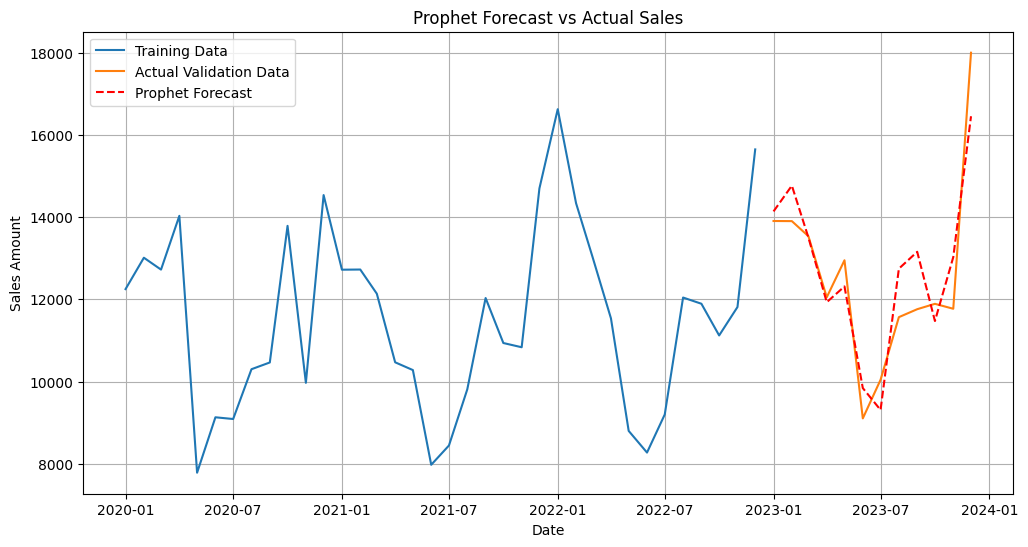

In [67]:
from prophet import Prophet

# Prepare data for Prophet: it requires columns named 'ds' and 'y'
prophet_train = train_data.reset_index()[['Date', 'SalesAmount']].rename(columns={'Date':'ds', 'SalesAmount':'y'})

# Add external regressors to training dataframe
prophet_train['Promotion'] = train_exog['Promotion'].values
prophet_train['HolidayMonth'] = train_exog['HolidayMonth'].values

# Initialize Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Add regressors (you must add these to the model explicitly)
model.add_regressor('Promotion')
model.add_regressor('HolidayMonth')

# Fit model on training data
model.fit(prophet_train)

# Prepare validation data in same format for prediction
prophet_valid = valid_data.reset_index()[['Date', 'SalesAmount']].rename(columns={'Date':'ds', 'SalesAmount':'y'})
prophet_valid['Promotion'] = valid_exog['Promotion'].values
prophet_valid['HolidayMonth'] = valid_exog['HolidayMonth'].values

# Make future dataframe for the validation period
future = prophet_valid[['ds', 'Promotion', 'HolidayMonth']]

# Forecast on validation data
p_forecast = model.predict(future)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(prophet_train['ds'], prophet_train['y'], label='Training Data')
plt.plot(prophet_valid['ds'], prophet_valid['y'], label='Actual Validation Data')
plt.plot(p_forecast['ds'], p_forecast['yhat'], label='Prophet Forecast', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Prophet Forecast vs Actual Sales')
plt.legend()
plt.grid(True)
plt.show()

**Model Evaluation and Forecasting**

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual validation sales
actual = valid_data['SalesAmount']

# Forecasts from your models
# These should be pandas Series indexed by date for proper alignment
arima_pred = forecast
sarimax_pred = sarimax_forecast
prophet_pred = p_forecast

# Function to calculate metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, mse, rmse, mape

# Evaluate ARIMA
arima_mae, arima_mse, arima_rmse, arima_mape = calculate_metrics(actual, arima_pred)

# Evaluate SARIMAX
sarimax_mae, sarimax_mse, sarimax_rmse, sarimax_mape = calculate_metrics(actual, sarimax_pred)

# Evaluate Prophet
# prophet_mae, prophet_mse, prophet_rmse, prophet_mape = calculate_metrics(actual, prophet_pred)

# Print results
print("=== ARIMA Model Performance ===")
print(f"MAE: {arima_mae:.2f}")
print(f"MSE: {arima_mse:.2f}")
print(f"RMSE: {arima_rmse:.2f}")
print(f"MAPE: {arima_mape:.2f}%\n")

print("=== SARIMAX Model Performance ===")
print(f"MAE: {sarimax_mae:.2f}")
print(f"MSE: {sarimax_mse:.2f}")
print(f"RMSE: {sarimax_rmse:.2f}")
print(f"MAPE: {sarimax_mape:.2f}%\n")

# print("=== Prophet Model Performance ===")
# print(f"MAE: {prophet_mae:.2f}")
# print(f"MSE: {prophet_mse:.2f}")
# print(f"RMSE: {prophet_rmse:.2f}")
# print(f"MAPE: {prophet_mape:.2f}%")


=== ARIMA Model Performance ===
MAE: 1770.87
MSE: 5700621.36
RMSE: 2387.60
MAPE: 12.96%

=== SARIMAX Model Performance ===
MAE: 2208.45
MSE: 7139336.08
RMSE: 2671.95
MAPE: 17.81%

